# Example: Physics-Infused Models - Part 1/2

- Author: Dr. Daning Huang
- Date: 11/09/2025
- Updated: 12/08/2025

## Introduction

In this example, we explore the possibility of incorporating partial physics-based knowledge into the model.  This is often the case when we know part of the governing equation and need to learn the rest from data.  This approach can be beneficial in multiple aspects:

- Since only part of the model is learnt, usually a **smaller dataset** would be needed, when compared to the purely data-driven models.
- The inclusion of physics enhances the **generalizability** of the model to unseen scenarios.
- Particularly, if the physics carries some parameters, one possibility is to learn the model using data from one parametric combination, and then directly apply to other combinations **without re-training** the model.

The physics-infused models considered here involve two scenarios: Physics-based model is known for

- **Full states**: We learn and apply algebraic corrections to dynamics, which are functions of the states.
- **Partial states**: Additional hidden states need to be learned from data, which then are used to correct the dynamics.

The two parts of this example consider each of the above, respectively.

An additional practical consideration is **interface to other code**, this is when the physics-based model is only available in another ecosystem (e.g., JAX instead of PyTorch).  Then to allow for backpropagation in `DyMAD`, some interface would be needed to pass the function evaluations and gradients.

Lastly, this example shows continuous-time dynamics, but the idea applies to discrete-time dynamics too.  An example of the latter is provided in the `DyMAD` repo, `scripts/pirom_res_dt`.

## Problem

This part considers a simple pendulum dynamics with damping.  Let the states be $x=[x_1,x_2]$, where $x_1=\theta$ is the angular displacement and $x_2=\dot{\theta}$ is the angular velocity.  In state-space form, the true dynamics is

$$
\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= - \frac{g}{l}\left( \sin(x_1) + \frac{1}{10} x_2 \right)
\end{aligned}\quad\text{or}\quad \dot{x} = f(x,p)
$$

where the parameter $p=[l]$ includes the length of the pendulum.

Now suppose we only know part of the dynamics

$$
\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= - \frac{g}{l}\left( \sin(x_1) + r \right)
\end{aligned}\quad\text{or}\quad \dot{x} = \hat{f}(x,r,p)
$$

where $r=r(x;\Theta)$ is a learnable residual force term.

For simplicity, since we know the true form of $r$, which is linear, we will just use a linear model $r(x)=\Theta x$.

## Case Setup

### The usuals

First, some imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import TemplateCorrAlg      # New object
from dymad.training import WeakFormTrainer
from dymad.utils import plot_multi_trajs, plot_summary, TrajectorySampler

Then, the data generation.  Note that we only sample a small range of states and there is a new section `p` for sampling parameters.  Note that here `p` is configured to fix to one parameter.

In [2]:
B = 16
N = 301
t_grid = np.linspace(0, 6, N)

g = 9.81
def f(t, x, p=[1.0]):
    dtheta = x[1]
    domega = - (g / p[0]) * (np.sin(x[0]) + 0.1 * x[1])
    return np.array([dtheta, domega])

In [ ]:
"""res_data.yaml
dims:
  states: 2
  inputs: 0
  observations: 2
  parameters: 1

x0:
  kind: uniform
  params:
    bounds:
      - [-0.5, 0.5]
      - [-0.5, 0.5]

p:                    # New section
  kind: uniform
  params:
    bounds:
      - [1.0, 1.0]

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

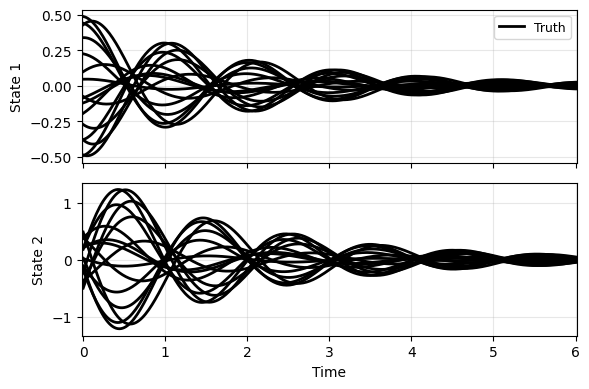

In [4]:
sampler = TrajectorySampler(f, config='res_data.yaml')
ts, xs, ys, ps = sampler.sample(t_grid, batch=B, save='./data/res.npz')
plot_multi_trajs(np.array([xs]), ts[0], "DP", labels=['Truth'], ifclose=False)

The configurations for model.  The only new thing here are the options `residual_layers` and `residual_dimension`, that define the depth and output dimension of $r$.  They are both one, to correspond to the assumed linear form.

We use weak form training for simplicity.

In [ ]:
"""res_model.yaml
data:
  path: './data/res.npz'
  n_samples: 16
  n_steps: 301
  double_precision: true

transform_x:
  type: "identity"

transform_u:
  type: "identity"

split:
  train_frac: 0.75

dataloader:
  batch_size: 256
"""

In [6]:
mdl_kl = {
    "name" : 'res_model',
    "residual_layers" : 1,       # New
    "residual_dimension" : 1,    # New
    "hidden_dimension" : 32,
    "activation" : "none",       # No activation for linear model
    "end_activation" : False,
    "weight_init" : "xavier_uniform",
    "gain" : 0.1,}               # Smaller initial weights for training stability

trn_wf = {
    "n_epochs": 300,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "weak_form_params": {
        "N": 29,
        "dN": 2,
        "ordpol": 2,
        "ordint": 2},
    }
config_path = 'res_model.yaml'

### Creating the model - Pure torch

Unlike other models, such as `KBF` and `LDM`, that can be used out of the box, to define a physics-infused model, we need to start from a `TemplateCorrAlg` class.  This class handles the interface to the other parts of `DyMAD` (training, plotting, etc.) and only needs one user-customized component: `base_dynamics`, which defines $\hat{f}$ discussed above.

> The main caveat is that the arguments are multi-dimensional, often in shapes of `[n_batch, n_step, n_dim]`.  Hence to access the desired variable, say $x_2$ in $x$, use indices `x[..., 1]`, where `...` represents all the dimensions except the last one.

In [7]:
class DPT(TemplateCorrAlg):
    CONT = True   # Tells the class to use continuous-time solver
    def base_dynamics(self, x: torch.Tensor, u: torch.Tensor, r: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        # x: states, in this case x=[x_1,x_2]
        # u: inputs, not used in this example
        # r: residual term, provided by a MLP, that is handled by the class
        # p: parameters, in this case p=[l]
        _f = torch.zeros_like(x)
        _f[..., 0] = x[..., 1]
        _f[..., 1] = - (g / p[..., 0]) * (torch.sin(x[..., 0]) + r[..., 0])
        return _f

### Creating the model - Interfacing with JAX

So far `DyMAD` provides an interface to `JAX`, which has native autodiff support.  The interfaces to other ecosystems, e.g., `NumPy` and `MATLAB`$\textregistered$ are still under development.

The JAX implementation is the following, which is nearly identical to the Torch case.

In [8]:
import jax.numpy as jnp

def f_jax(*args):
    x, u, r, p = args
    y1 = x[..., 1]
    y2 = - (g / p[..., 0]) * (jnp.sin(x[..., 0]) + r[..., 0])
    return jnp.stack([y1, y2], axis=-1)

Then we use a `JaxWrapper` to create the interface, still under the `TemplateCorrAlg` class.

In [9]:
from dymad.utils import JaxWrapper

class DPJ(TemplateCorrAlg):
    CONT = True
    def extra_setup(self):
        # Additional step to include the JAX interface, jit makes the jax function faster.
        # This function is called at the end of __init__ of this class
        self._jax_layer = JaxWrapper(f_jax, jit=True)

    def base_dynamics(self, x: torch.Tensor, u: torch.Tensor, r: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        # Instead of having the implementation here, the dynamics is provided via JAX.
        return self._jax_layer(x, u, r, p)

## Training

Now we have two customized models, but the training is the same.  After training we also show the convergence histories, which are approximately the same.  The main difference is that the JAX version is slower; this is unavoidable due to the switching between JAX and Torch.

In [10]:
cfgs = [
    ('dp_wf', DPT, WeakFormTrainer, {"model": mdl_kl, "training" : trn_wf}),
    ('dj_wf', DPJ, WeakFormTrainer, {"model": mdl_kl, "training" : trn_wf}),
    ]
IDX = [0, 1]
labels = [cfgs[i][0] for i in IDX]

In [11]:
for i in IDX:
    mdl, MDL, Trainer, opt = cfgs[i]
    opt["model"]["name"] = f"res_{mdl}"
    trainer = Trainer(config_path, MDL, config_mod=opt)
    trainer.train()

Epoch time dp_wf: 0.000804747740427653
Epoch time dj_wf: 0.002723183631896973


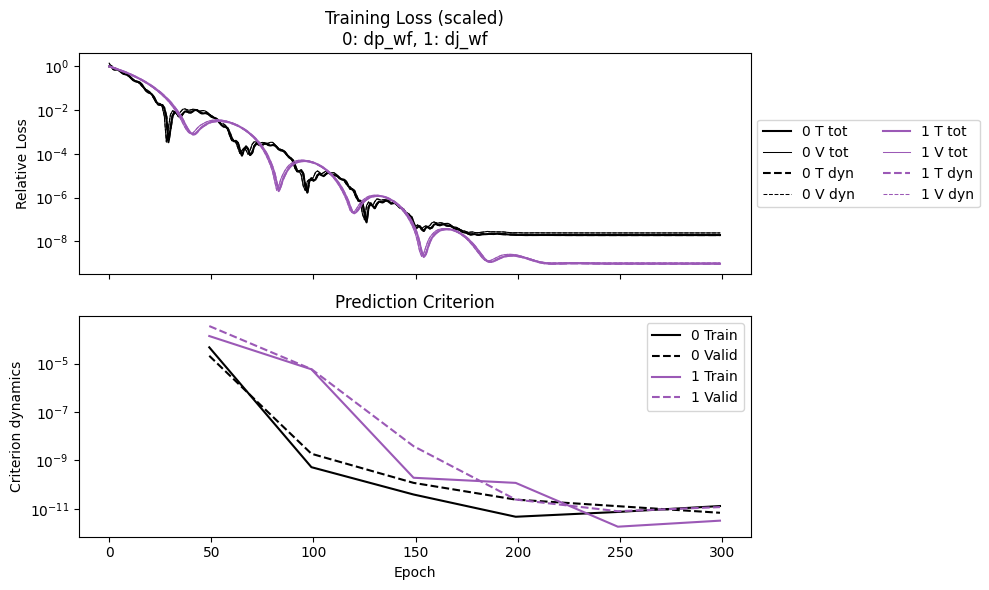

In [12]:
npz_files = [f'res_{l}' for l in labels]
npzs = plot_summary(npz_files, labels=labels, ifclose=False)

for lbl, npz in zip(labels, npzs):
    print(f"Epoch time {lbl}: {npz['avg_epoch_time']}")

## Prediction

Lastly the prediction.  Compared to the training data, here we try initial conditions of a 4-times-larger domain and multiple new parameters.

But it should not be surprising that the models extrapolate well to both cases, thanks to the physics infused in the model.

The two models also performs similarly, since their mathematical formulations are the same.  The difference comes from training.

In [ ]:
"""res_test.yaml
dims:
  states: 2
  inputs: 0
  observations: 2
  parameters: 1

x0:
  kind: uniform
  params:
    bounds:
      - [-2.0, 2.0]
      - [-2.0, 2.0]

p:
  kind: uniform
  params:
    bounds:
      - [1.0, 5.0]

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

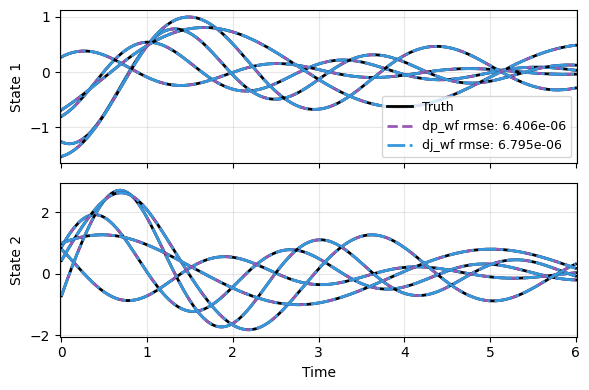

In [15]:
sampler = TrajectorySampler(f, config='res_test.yaml')
ts, xs, ys, ps = sampler.sample(t_grid, batch=5)
x_data = xs
t_data = ts[0]
p_data = ps

res = [x_data]
for i in IDX:
    mdl, MDL, _, _ = cfgs[i]
    _, prd_func = load_model(MDL, f'res_{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(x_data, t_data, p=p_data)
    res.append(pred)

plot_multi_trajs(
    np.array(res), t_data, "DP",
    labels=['Truth'] + labels, ifclose=False)